In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [95]:
PASTA_DADOS = "dados_UTI"

# Carregar os arquivos CSV
arquivos = {
    arquivo.split('.')[0]: pd.read_csv(os.path.join(PASTA_DADOS, arquivo))
    for arquivo in os.listdir(PASTA_DADOS) if arquivo.endswith(".csv")
}

# Atribuir os DataFrames
admissions_df = arquivos.get("admissions")
patients_df = arquivos.get("patients")
prescriptions_df = arquivos.get("prescriptions")
procedureevents_df = arquivos.get("procedureevents")
icustays_df = arquivos.get("icustays")
diagnoses_df = arquivos.get("diagnoses_icd")
icd_descriptions_df = arquivos.get("d_icd_diagnoses")
labevents_df = arquivos.get("labevents")
chartevents_df = arquivos.get("chartevents")

# Converter colunas de tempo para datetime
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'], errors='coerce')
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'], errors='coerce')
icustays_df['intime'] = pd.to_datetime(icustays_df['intime'], errors='coerce')
icustays_df['outtime'] = pd.to_datetime(icustays_df['outtime'], errors='coerce')
patients_df['dod'] = pd.to_datetime(patients_df['dod'], errors='coerce')

In [96]:
# 📌 Calcular tempo de internação
admissions_df['hospital_los'] = (admissions_df['dischtime'] - admissions_df['admittime']).dt.total_seconds() / (24 * 3600)
icustays_df['icu_los'] = (icustays_df['outtime'] - icustays_df['intime']).dt.total_seconds() / (24 * 3600)

# 📌 Filtrar apenas os pacientes que foram para a UTI
pacientes_uti = admissions_df.merge(icustays_df[['subject_id', 'stay_id', 'icu_los']], on="subject_id", how="inner")

# 📌 Calcular número de pacientes que realmente morreram na UTI
mortes_na_uti = icustays_df.merge(
    admissions_df[['subject_id', 'hadm_id', 'deathtime']],
    on=['subject_id', 'hadm_id'],
    how='left'
)

mortes_na_uti = mortes_na_uti[
    (mortes_na_uti['deathtime'].notna()) &
    (mortes_na_uti['deathtime'] >= mortes_na_uti['intime']) &
    (mortes_na_uti['deathtime'] <= mortes_na_uti['outtime'])
]

# 📌 Estatísticas
total_pacientes_uti = pacientes_uti['subject_id'].nunique()
num_obitos_uti = mortes_na_uti['subject_id'].nunique()
num_sobreviventes_uti = total_pacientes_uti - num_obitos_uti
taxa_mortalidade_uti = (num_obitos_uti / total_pacientes_uti) * 100
tempo_medio_uti = icustays_df['icu_los'].mean()

# 📌 Distribuição de Gênero
genero_contagem = patients_df['gender'].value_counts().to_dict()

# 📌 Exibir estatísticas
print("\n📊 Estatísticas Gerais dos Pacientes na UTI:")
print(f"• Total de Pacientes na UTI: {total_pacientes_uti}")
print(f"• Pacientes que sobreviveram: {num_sobreviventes_uti}")
print(f"• Pacientes que faleceram na UTI: {num_obitos_uti}")
print(f"• Taxa de Mortalidade na UTI: {taxa_mortalidade_uti:.2f}%")
print(f"• Tempo médio de internação na UTI: {tempo_medio_uti:.2f} dias\n")

print("📊 Distribuição de Gênero:")
for genero, contagem in genero_contagem.items():
    print(f"• {genero}: {contagem} pacientes")



📊 Estatísticas Gerais dos Pacientes na UTI:
• Total de Pacientes na UTI: 100
• Pacientes que sobreviveram: 88
• Pacientes que faleceram na UTI: 12
• Taxa de Mortalidade na UTI: 12.00%
• Tempo médio de internação na UTI: 3.68 dias

📊 Distribuição de Gênero:
• M: 57 pacientes
• F: 43 pacientes


In [97]:
# 📌 Filtrar apenas os diagnósticos dos pacientes que foram para a UTI
diagnoses_uti = diagnoses_df.merge(pacientes_uti[['subject_id']], on="subject_id", how="inner")

# 📌 Unir com as descrições dos diagnósticos
diagnoses_uti = diagnoses_uti.merge(
    icd_descriptions_df[['icd_code', 'long_title']], on='icd_code', how='left'
)

# 📌 Criar categorias temáticas principais
def categorizar_diagnostico(texto):
    texto = texto.lower()
    if "tobacco" in texto or "smoking" in texto:
        return "Tabagismo"
    elif "lipid" in texto or "hyperlipidemia" in texto:
        return "Hiperlipidemia"
    elif "hypertension" in texto:
        return "Hipertensão"
    elif "diabetes" in texto:
        return "Diabetes"
    elif "anemia" in texto:
        return "Anemia"
    elif "atrial fibrillation" in texto:
        return "Fibrilação Atrial"
    elif "coronary atherosclerosis" in texto:
        return "Aterosclerose Coronária"
    else:
        return "Outros"

# 📌 Aplicar categorias aos diagnósticos
diagnoses_uti['Categoria Diagnóstico'] = diagnoses_uti['long_title'].apply(categorizar_diagnostico)

# 📌 Contar pacientes únicos por categoria
diagnosticos_agrupados = diagnoses_uti.groupby("Categoria Diagnóstico")["subject_id"].nunique().reset_index()
diagnosticos_agrupados.columns = ["Categoria", "Número de Pacientes"]
diagnosticos_agrupados = diagnosticos_agrupados.sort_values(by="Número de Pacientes", ascending=False)

# 📌 Exibir os resultados
from IPython.display import display

print("\n📊 Top Diagnósticos Agrupados por Categoria Temática\n")
display(diagnosticos_agrupados)



📊 Top Diagnósticos Agrupados por Categoria Temática



,Categoria,Número de Pacientes
6,Outros,100
5,Hipertensão,64
0,Anemia,47
4,Hiperlipidemia,47
7,Tabagismo,39
2,Diabetes,35
3,Fibrilação Atrial,30
1,Aterosclerose Coronária,22


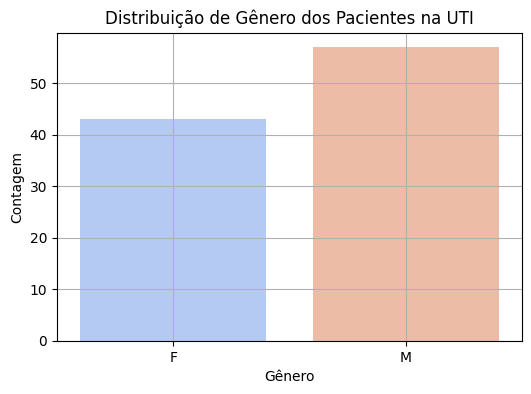

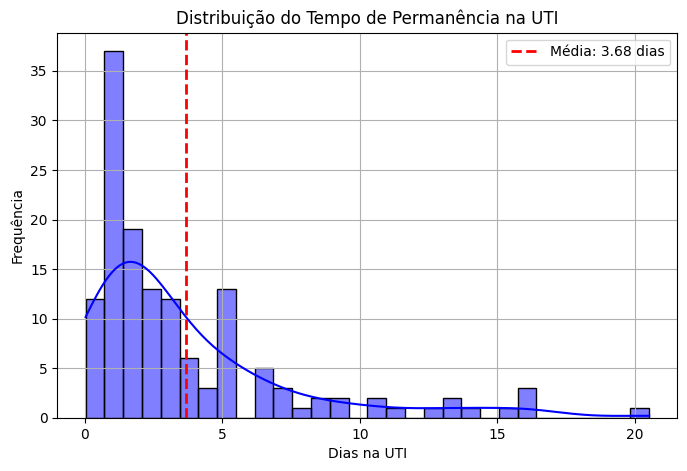

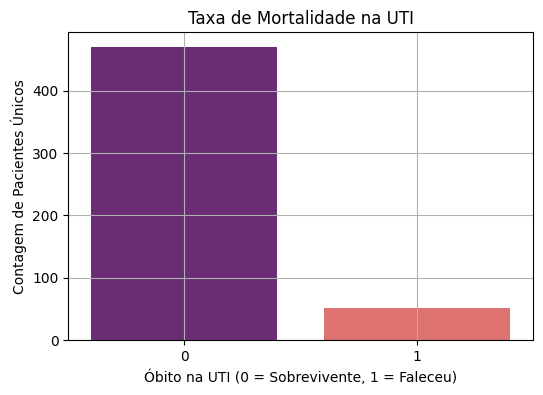

In [98]:
# 📊 Distribuição de Gênero
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=patients_df, hue='gender', palette="coolwarm", legend=False)
plt.xlabel("Gênero")
plt.ylabel("Contagem")
plt.title("Distribuição de Gênero dos Pacientes na UTI")
plt.grid(True)
plt.savefig("distribuicao_genero_uti.png", dpi=300)
plt.show()

# 📊 Distribuição do Tempo Médio de Internação na UTI com Linha de Média
plt.figure(figsize=(8, 5))
sns.histplot(icustays_df['icu_los'].dropna(), bins=30, kde=True, color="blue")
plt.axvline(tempo_medio_uti, color='red', linestyle='dashed', linewidth=2, label=f'Média: {tempo_medio_uti:.2f} dias')
plt.xlabel("Dias na UTI")
plt.ylabel("Frequência")
plt.title("Distribuição do Tempo de Permanência na UTI")
plt.legend()
plt.grid(True)
plt.savefig("tempo_medio_internacao_uti.png", dpi=300)
plt.show()

# 📊 Gráfico da mortalidade na UTI
pacientes_uti["morreu_na_uti"] = pacientes_uti["subject_id"].isin(mortes_na_uti["subject_id"]).astype(int)

plt.figure(figsize=(6, 4))
sns.countplot(
    x="morreu_na_uti",
    hue="morreu_na_uti",
    data=pacientes_uti,
    palette="magma",
    legend=False
)
plt.xlabel("Óbito na UTI (0 = Sobrevivente, 1 = Faleceu)")
plt.ylabel("Contagem de Pacientes Únicos")
plt.title("Taxa de Mortalidade na UTI")
plt.grid(True)
plt.savefig("mortalidade_na_uti", dpi=300)
plt.show()

In [99]:
# 📌 Lista de Vasopressores de Interesse
vasopressores = ["dopamine", "epinephrine", "norepinephrine", "phenylephrine", "vasopressin"]

# 📌 Filtrar pacientes que receberam vasopressores (sem duplicatas)
pacientes_vasopressores = prescriptions_df[
    prescriptions_df['drug'].str.contains('|'.join(vasopressores), case=False, na=False)
][['subject_id']].drop_duplicates()

# 📌 Criar grupo de pacientes que não usaram vasopressores (sem duplicatas)
pacientes_sem_vasopressores = pacientes_uti[~pacientes_uti["subject_id"].isin(pacientes_vasopressores["subject_id"])]
pacientes_sem_vasopressores = pacientes_sem_vasopressores[['subject_id']].drop_duplicates()

# 📌 Usar mortes_na_uti já calculado anteriormente
ids_mortes_na_uti = mortes_na_uti['subject_id'].unique()

# 📌 Contar óbitos nos dois grupos
num_pacientes_vasopressores = pacientes_vasopressores['subject_id'].nunique()
num_obitos_vasopressores = pacientes_vasopressores[
    pacientes_vasopressores['subject_id'].isin(ids_mortes_na_uti)
]['subject_id'].nunique()

num_pacientes_sem_vasopressores = pacientes_sem_vasopressores['subject_id'].nunique()
num_obitos_sem_vasopressores = pacientes_sem_vasopressores[
    pacientes_sem_vasopressores['subject_id'].isin(ids_mortes_na_uti)
]['subject_id'].nunique()

# 📌 Calcular taxas de mortalidade
taxa_mortalidade_vasopressores = (num_obitos_vasopressores / num_pacientes_vasopressores) * 100
taxa_mortalidade_sem_vasopressores = (num_obitos_sem_vasopressores / num_pacientes_sem_vasopressores) * 100

# 📌 Criar DataFrame de comparação
tabela_mortalidade = pd.DataFrame({
    "Grupo": ["Com Vasopressores", "Sem Vasopressores"],
    "Número de Pacientes": [num_pacientes_vasopressores, num_pacientes_sem_vasopressores],
    "Óbitos": [num_obitos_vasopressores, num_obitos_sem_vasopressores],
    "Taxa de Mortalidade (%)": [taxa_mortalidade_vasopressores, taxa_mortalidade_sem_vasopressores]
})

print("\n📊 Comparação de Mortalidade entre Pacientes que Usaram e Não Usaram Vasopressores (Na UTI)\n")
print(tabela_mortalidade.to_string(index=False))


📊 Comparação de Mortalidade entre Pacientes que Usaram e Não Usaram Vasopressores (Na UTI)

            Grupo  Número de Pacientes  Óbitos  Taxa de Mortalidade (%)
Com Vasopressores                   53      10                18.867925
Sem Vasopressores                   47       2                 4.255319



📊 **Comparação de Mortalidade entre Pacientes com e sem Ventilação Mecânica (Na UTI)**

                  Grupo  Número de Pacientes  Óbitos  Taxa de Mortalidade (%)
Com Ventilação Mecânica                   55      10                18.181818
Sem Ventilação Mecânica                   45       2                 4.444444


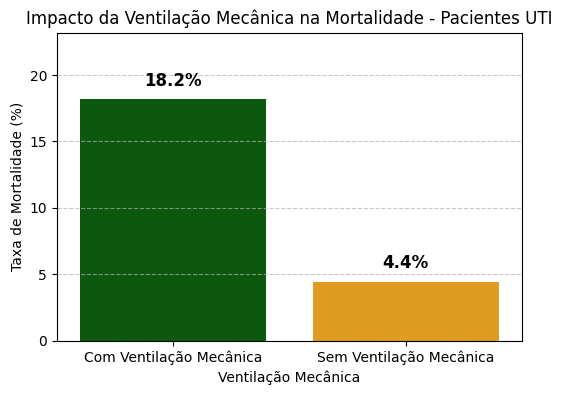

In [100]:
# 📌 Filtrar procedimentos de ventilação mecânica
ventilacao_df = procedureevents_df[procedureevents_df['ordercategoryname'].str.contains("Ventilation", case=False, na=False)]
pacientes_ventilacao = ventilacao_df[['subject_id']].drop_duplicates()
pacientes_ventilacao['ventilacao'] = 1

# 📌 Criar coluna de ventilação no dataframe de pacientes da UTI
pacientes_uti = pacientes_uti.merge(pacientes_ventilacao, on='subject_id', how='left')
pacientes_uti['ventilacao'] = pacientes_uti['ventilacao'].fillna(0)

# 📌 Separar os dois grupos
grupo_com_ventilacao = pacientes_uti[pacientes_uti['ventilacao'] == 1]
grupo_sem_ventilacao = pacientes_uti[pacientes_uti['ventilacao'] == 0]

# 📌 Usar mortes_na_uti já calculado anteriormente
ids_mortes_na_uti = mortes_na_uti['subject_id'].unique()

# 📌 Contar óbitos nos dois grupos com base em morte na UTI
num_pacientes_ventilacao = grupo_com_ventilacao['subject_id'].nunique()
num_obitos_ventilacao = grupo_com_ventilacao[
    grupo_com_ventilacao['subject_id'].isin(ids_mortes_na_uti)
]['subject_id'].nunique()

num_pacientes_sem_ventilacao = grupo_sem_ventilacao['subject_id'].nunique()
num_obitos_sem_ventilacao = grupo_sem_ventilacao[
    grupo_sem_ventilacao['subject_id'].isin(ids_mortes_na_uti)
]['subject_id'].nunique()

# 📌 Calcular taxas de mortalidade
taxa_mortalidade_ventilacao = (num_obitos_ventilacao / num_pacientes_ventilacao) * 100
taxa_mortalidade_sem_ventilacao = (num_obitos_sem_ventilacao / num_pacientes_sem_ventilacao) * 100

# 📌 Criar DataFrame de comparação
tabela_mortalidade_ventilacao = pd.DataFrame({
    "Grupo": ["Com Ventilação Mecânica", "Sem Ventilação Mecânica"],
    "Número de Pacientes": [num_pacientes_ventilacao, num_pacientes_sem_ventilacao],
    "Óbitos": [num_obitos_ventilacao, num_obitos_sem_ventilacao],
    "Taxa de Mortalidade (%)": [taxa_mortalidade_ventilacao, taxa_mortalidade_sem_ventilacao]
})

print("\n📊 **Comparação de Mortalidade entre Pacientes com e sem Ventilação Mecânica (Na UTI)**\n")
print(tabela_mortalidade_ventilacao.to_string(index=False))

# 📌 Criar gráfico
plt.figure(figsize=(6, 4))
sns.barplot(x="Grupo", y="Taxa de Mortalidade (%)", hue="Grupo", data=tabela_mortalidade_ventilacao, palette=["darkgreen", "orange"], legend=False)
plt.ylabel("Taxa de Mortalidade (%)")
plt.xlabel("Ventilação Mecânica")
plt.title("Impacto da Ventilação Mecânica na Mortalidade - Pacientes UTI")
plt.ylim(0, max(tabela_mortalidade_ventilacao["Taxa de Mortalidade (%)"]) + 5)
for i, row in tabela_mortalidade_ventilacao.iterrows():
    plt.text(i, row["Taxa de Mortalidade (%)"] + 1, f"{row['Taxa de Mortalidade (%)']:.1f}%", ha='center', fontsize=12, fontweight='bold')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("impacto_ventilacao_mortalidade.png", dpi=300)
plt.show()


,Grupo,Número de Pacientes,Óbitos,Taxa de Mortalidade (%)
0,Com TSR,4,1,25.000000
1,Sem TSR,96,11,11.458333


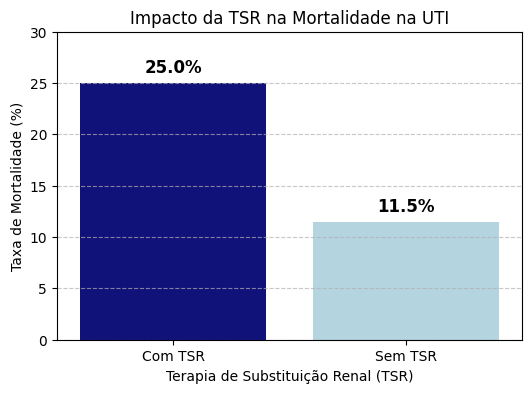

In [101]:
# 📌 Adicionar flag de TSR ao dataframe de admissões 
tsr_procedures = ["Dialysis", "CRRT Filter Change"]
pacientes_tsr = procedureevents_df[procedureevents_df["ordercategoryname"].isin(tsr_procedures)][["subject_id"]].drop_duplicates()
pacientes_tsr["TSR"] = 1

admissions_df = admissions_df.drop(columns=["TSR"], errors='ignore')  # limpar se já tiver
admissions_df = admissions_df.merge(pacientes_tsr, on="subject_id", how="left")
admissions_df["TSR"] = admissions_df["TSR"].fillna(0)

# 📌 Criar DataFrame com pacientes únicos (evitar múltiplas admissões)
pacientes_adm_unicos = admissions_df[['subject_id', 'TSR']].drop_duplicates()

# 📌 Usar mortes_na_uti já calculado anteriormente
ids_mortes_na_uti = mortes_na_uti["subject_id"].unique()

# 📌 Contar óbitos na UTI nos dois grupos (sem duplicatas)
grupo_com_tsr = pacientes_adm_unicos[pacientes_adm_unicos["TSR"] == 1]
grupo_sem_tsr = pacientes_adm_unicos[pacientes_adm_unicos["TSR"] == 0]

num_pacientes_tsr = grupo_com_tsr['subject_id'].nunique()
num_obitos_tsr = grupo_com_tsr[
    grupo_com_tsr["subject_id"].isin(ids_mortes_na_uti)
]['subject_id'].nunique()

num_pacientes_sem_tsr = grupo_sem_tsr['subject_id'].nunique()
num_obitos_sem_tsr = grupo_sem_tsr[
    grupo_sem_tsr["subject_id"].isin(ids_mortes_na_uti)
]['subject_id'].nunique()

# 📌 Calcular taxas de mortalidade
taxa_mortalidade_tsr = (num_obitos_tsr / num_pacientes_tsr) * 100 if num_pacientes_tsr > 0 else 0
taxa_mortalidade_sem_tsr = (num_obitos_sem_tsr / num_pacientes_sem_tsr) * 100 if num_pacientes_sem_tsr > 0 else 0

# 📌 Criar tabela de comparação
tabela_mortalidade_tsr = pd.DataFrame({
    "Grupo": ["Com TSR", "Sem TSR"],
    "Número de Pacientes": [num_pacientes_tsr, num_pacientes_sem_tsr],
    "Óbitos": [num_obitos_tsr, num_obitos_sem_tsr],
    "Taxa de Mortalidade (%)": [taxa_mortalidade_tsr, taxa_mortalidade_sem_tsr]
})

from IPython.display import display
display(tabela_mortalidade_tsr)

# 📊 Gráfico
plt.figure(figsize=(6, 4))
sns.barplot(
    x="Grupo",
    y="Taxa de Mortalidade (%)",
    hue="Grupo",
    data=tabela_mortalidade_tsr,
    palette=["darkblue", "lightblue"],
    legend=False
)
plt.ylabel("Taxa de Mortalidade (%)")
plt.xlabel("Terapia de Substituição Renal (TSR)")
plt.title("Impacto da TSR na Mortalidade na UTI")
plt.ylim(0, max(tabela_mortalidade_tsr["Taxa de Mortalidade (%)"]) + 5)

# 📌 Adicionar valores no topo das barras
for i, row in tabela_mortalidade_tsr.iterrows():
    plt.text(i, row["Taxa de Mortalidade (%)"] + 1, f"{row['Taxa de Mortalidade (%)']:.1f}%", ha='center', fontsize=12, fontweight='bold')

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("impacto_tsr_mortalidade.png", dpi=300)
plt.show()


📊 Tabela de Mortalidade por Categoria

          Categoria  Quantidade
   Mortes Intra-UTI          12
Mortes Hospitalares           3
Mortes em até 1 Ano          16


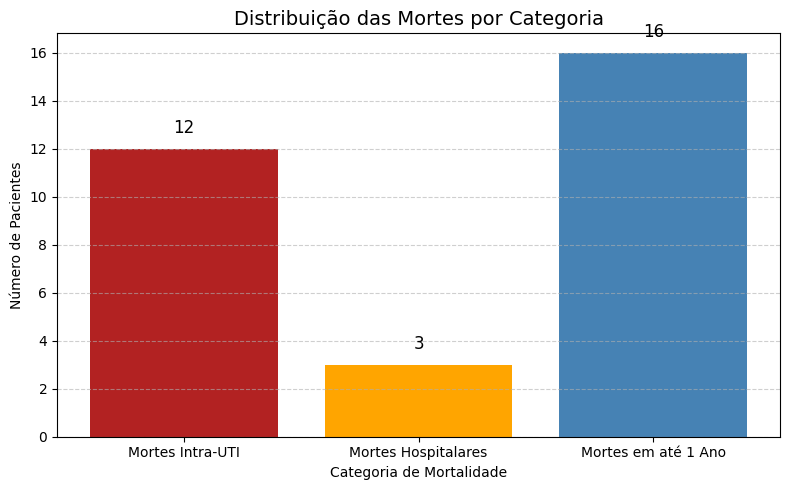

In [102]:
# 📌 Mortes Intra-UTI (pacientes que morreram durante a permanência na UTI)
mortalidade_intra_uti = icustays_df.merge(
    admissions_df[['subject_id', 'hadm_id', 'deathtime']],
    on=['subject_id', 'hadm_id'],
    how='left'
)
mortalidade_intra_uti = mortalidade_intra_uti[
    (mortalidade_intra_uti['deathtime'].notna()) &
    (mortalidade_intra_uti['deathtime'] >= mortalidade_intra_uti['intime']) &
    (mortalidade_intra_uti['deathtime'] <= mortalidade_intra_uti['outtime'])
][['subject_id']].drop_duplicates()

# 📌 Mortes Hospitalares (pacientes que morreram no hospital após sair da UTI)
mortalidade_hospitalar = admissions_df[
    (admissions_df['hospital_expire_flag'] == 1) &
    (~admissions_df['subject_id'].isin(mortalidade_intra_uti['subject_id'])) &
    (admissions_df['subject_id'].isin(icustays_df['subject_id']))
][['subject_id']].drop_duplicates()

# 📌 Passo 1: identificar a última admissão hospitalar de cada paciente
ultima_admissao = admissions_df.sort_values(['subject_id', 'dischtime'], ascending=[True, False])
ultima_admissao = ultima_admissao.drop_duplicates(subset='subject_id', keep='first')

# 📌 Passo 2: associar à última passagem pela UTI (com base na outtime mais recente)
icustay_ultima_adm = icustays_df.sort_values(['subject_id', 'outtime'], ascending=[True, False])
icustay_ultima_adm = icustay_ultima_adm.drop_duplicates(subset='subject_id', keep='first')

# 📌 Passo 3: combinar com pacientes (para pegar a data de óbito)
mortalidade_1_ano_corrigida = ultima_admissao.merge(
    patients_df[['subject_id', 'dod']],
    on='subject_id',
    how='left'
).merge(
    icustay_ultima_adm[['subject_id', 'outtime']],
    on='subject_id',
    how='left'
)

# 📌 Passo 4: aplicar filtros
mortalidade_1_ano_corrigida = mortalidade_1_ano_corrigida[
    (mortalidade_1_ano_corrigida['hospital_expire_flag'] == 0) &                      # saiu vivo do hospital
    (mortalidade_1_ano_corrigida['dod'].notna()) &                                    # tem data de óbito
    (mortalidade_1_ano_corrigida['dischtime'].notna()) &                              # tem data de alta
    (mortalidade_1_ano_corrigida['outtime'].notna()) &                                # tem saída da UTI
    (mortalidade_1_ano_corrigida['dod'] > mortalidade_1_ano_corrigida['outtime']) &   # morreu após sair da UTI
    ((mortalidade_1_ano_corrigida['dod'] - mortalidade_1_ano_corrigida['dischtime']).dt.days <= 365)  # até 1 ano
]

# 📌 Passo 5: excluir pacientes que já morreram na UTI ou no hospital
mortalidade_1_ano_corrigida = mortalidade_1_ano_corrigida[
    (~mortalidade_1_ano_corrigida['subject_id'].isin(mortalidade_intra_uti['subject_id'])) &
    (~mortalidade_1_ano_corrigida['subject_id'].isin(mortalidade_hospitalar['subject_id']))
][['subject_id']].drop_duplicates()

# 📌 Atualizar a tabela final
tabela_mortalidade_final = pd.DataFrame({
    "Categoria": ["Mortes Intra-UTI", "Mortes Hospitalares", "Mortes em até 1 Ano"],
    "Quantidade": [
        mortalidade_intra_uti['subject_id'].nunique(),
        mortalidade_hospitalar['subject_id'].nunique(),
        mortalidade_1_ano_corrigida['subject_id'].nunique()
    ]
})

# 📌 Exibir resultado
print("\n📊 Tabela de Mortalidade por Categoria\n")
print(tabela_mortalidade_final.to_string(index=False))

plt.figure(figsize=(8, 5))
plt.bar(tabela_mortalidade_final["Categoria"], tabela_mortalidade_final["Quantidade"], color=["firebrick", "orange", "steelblue"])
plt.title("Distribuição das Mortes por Categoria", fontsize=14)
plt.ylabel("Número de Pacientes")
plt.xlabel("Categoria de Mortalidade")
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Adicionar os valores acima das barras
for i, quantidade in enumerate(tabela_mortalidade_final["Quantidade"]):
    plt.text(i, quantidade + 0.5, str(quantidade), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

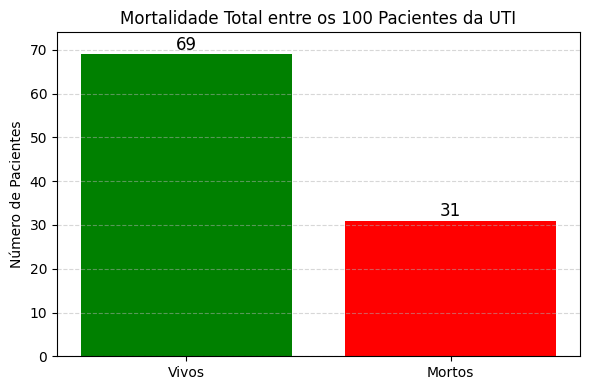

In [103]:
# 📌 Carregar o dataset
dataset_uti = pd.read_csv("dataset_UTI_completo.csv")

# 📌 Criar coluna de mortalidade total
dataset_uti['mortalidade_total'] = (
    (dataset_uti['morte_na_uti'] == 1) |
    (dataset_uti['morte_hospitalar'] == 1) |
    (dataset_uti['morte_1ano'] == 1)
).astype(int)

# 📊 Contagem de vivos e mortos
contagem = dataset_uti['mortalidade_total'].value_counts().rename(index={0: "Vivos", 1: "Mortos"})

# 📈 Gráfico
plt.figure(figsize=(6,4))
bars = plt.bar(contagem.index, contagem.values, color=["green", "red"])
plt.title("Mortalidade Total entre os 100 Pacientes da UTI")
plt.ylabel("Número de Pacientes")
plt.ylim(0, max(contagem.values) + 5)

# Adiciona os valores no topo das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{int(yval)}', ha='center', fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()